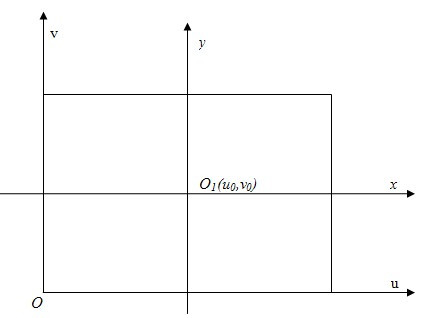

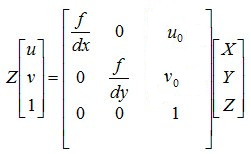

In [4]:
import imutils
import cv2,math
import numpy as np
from keras.preprocessing.image import img_to_array
# 导入必要的软件包

def image_dealwith(img):
    #图像灰度处理
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (21, 21), 0)

    gradX = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
    gradY = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=-1)
    # subtract the y-gradient from the x-gradient
    gradient = cv2.subtract(gradX, gradY)
    gradient = cv2.convertScaleAbs(gradient)

    # blur and threshold the image
    blurred = cv2.blur(gradient, (9, 9))
    (_, thresh) = cv2.threshold(blurred, 140, 120, cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 25))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # perform a series of erosions and dilations
    closed = cv2.erode(closed, None, iterations=4)
    closed = cv2.dilate(closed, None, iterations=4)
    return closed

def pixel_to_camera(fx,fy,u0,v0,u,v,Z):
    #将像素坐标转换为相机坐标
    X = (u-u0)*abs(Z)/fx
    Y = (v-v0)*abs(Z)/fy
    return X,Y,Z

def camera_to_pixel(fx,fy,u0,v0,X,Y,Z):
    #将相机坐标转换为像素坐标
    K = np.array([[fx,0,u0],[0,fy,v0],[0,0,1]])
    camera = np.array([[X],[Y],[Z]])
    pixel = np.dot(K,camera)/Z
    pixel = pixel.T
    u,v = pixel[0][0],pixel[0][1]
    return u,v

def angle_to_arc(angle):
    import math
    pi = math.pi
    arc = angle/180*pi
    return arc

def world_to_camera(theta_x,theta_y,theta_z,T,Ow):
    #将世界坐标转换为相机坐标
    Rx = np.array([[1,0,0],
                   [0,math.cos(angle_to_arc(theta_x)),math.sin(angle_to_arc(theta_x))],
                   [0,-math.sin(angle_to_arc(theta_x)),math.cos(angle_to_arc(theta_x))]])
    Ry = np.array([[math.cos(angle_to_arc(theta_y)),0,-math.sin(angle_to_arc(theta_y))],
                   [0,1,0],
                   [math.sin(angle_to_arc(theta_y)),0,math.cos(angle_to_arc(theta_y))]])
    Rz = np.array([[math.cos(angle_to_arc(theta_z)),math.sin(angle_to_arc(theta_z)),0],
                   [-math.sin(angle_to_arc(theta_z)),math.cos(angle_to_arc(theta_z)),0],
                   [0,0,1]])
    R= np.dot(np.dot(Rx,Ry),Rz)
    print(R)
    Oc = np.dot(R,Ow) + T
    return Oc.T

def camera_to_world(theta_x,theta_y,theta_z,T,Oc):
    #将相机坐标转换为世界坐标
    Rx = np.array([[1,0,0],
                   [0,math.cos(angle_to_arc(theta_x)),math.sin(angle_to_arc(theta_x))],
                   [0,-math.sin(angle_to_arc(theta_x)),math.cos(angle_to_arc(theta_x))]])
    Ry = np.array([[math.cos(angle_to_arc(theta_y)),0,-math.sin(angle_to_arc(theta_y))],
                   [0,1,0],
                   [math.sin(angle_to_arc(theta_y)),0,math.cos(angle_to_arc(theta_y))]])
    Rz = np.array([[math.cos(angle_to_arc(theta_z)),math.sin(angle_to_arc(theta_z)),0],
                   [-math.sin(angle_to_arc(theta_z)),math.cos(angle_to_arc(theta_z)),0],
                   [0,0,1]])

    R= np.dot(np.dot(Rx,Ry),Rz)
    R_N = np.linalg.inv(R)
    Ow = np.dot(R_N,Oc) - T
    
    return Ow

def text_save(filename, data):#filename为写入CSV文件的路径，data为要写入数据列表.
    file = open(filename,'w')
    for i in range(len(data)):
        s = str(data[i]).replace('[','').replace(']','')#去除[],这两行按数据不同，可以选择
        s = s.replace("'",'').replace(',','') +'  '   #去除单引号，逗号，每行末尾追加换行符
        file.write(s)
    file.close()
    print("保存文件成功")

Using TensorFlow backend.


In [5]:
frame = cv2.imread('./CHE_0_5.jpg')
closed = image_dealwith(frame)
(_,cnts, _) = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for c in cnts:
    rect = cv2.contourArea(c)
    #可以通过if语句筛选掉小框
    (x, y, w, h) = cv2.boundingRect(c)
    print(x+w/2,y+h/2)
    pixel_u = x+w/2
    pixel_v = y+h/2
    
#     X,Y,Z = pixel_to_camera(657.3844,658.0580,320.6258,240.8434,x+w/2,y+h/2,420)
    X,Y,Z = pixel_to_camera(657.3844,658.0580,320.6258,240.8434,pixel_u,pixel_v,420)
    print(X,Y,Z)
    
    T = np.array([[700],[0],[200]])
    Oc = np.array([[X],[Y],[Z]])
    Ow = camera_to_world(180,0,-90,T,Oc)#绕x180，绕z90度
    print(Ow.T[0])
    xw,yw,zw = Ow.T[0][0],Ow.T[0][1],Ow.T[0][2]
    text_save('./data.txt',Ow.T[0])
    
    crop_imgae = frame[y:y+h,x:x+w]#分割图像进行识别
    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(frame, "Pixel Position: ({},{})".format(x+w/2,y+h/2), (10, 20),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    cv2.putText(frame, "World Position: ({},{},{})".format(round(xw,2),round(yw,2),round(zw,2)), (10, 40),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    cv2.imshow("Security Feed", frame)
    cv2.waitKey(0)

537.5 389.0
138.5599719129325 94.55970750298606 420
[-794.5597075  -138.55997191 -620.        ]
保存文件成功


In [4]:
import imutils
import cv2,math
import numpy as np
from keras.preprocessing.image import img_to_array
# 导入必要的软件包

def image_dealwith(img):
    #图像灰度处理
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (21, 21), 0)

    gradX = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
    gradY = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=-1)
    # subtract the y-gradient from the x-gradient
    gradient = cv2.subtract(gradX, gradY)
    gradient = cv2.convertScaleAbs(gradient)

    # blur and threshold the image
    blurred = cv2.blur(gradient, (9, 9))
    (_, thresh) = cv2.threshold(blurred, 140, 120, cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 25))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # perform a series of erosions and dilations
    closed = cv2.erode(closed, None, iterations=4)
    closed = cv2.dilate(closed, None, iterations=4)
    return closed

def pixel_to_camera(fx,fy,u0,v0,u,v,Z):
    #将像素坐标转换为相机坐标
    X = (u-u0)*abs(Z)/fx
    Y = (v-v0)*abs(Z)/fy
    return X,Y,Z

def camera_to_pixel(fx,fy,u0,v0,X,Y,Z):
    #将相机坐标转换为像素坐标
    K = np.array([[fx,0,u0],[0,fy,v0],[0,0,1]])
    camera = np.array([[X],[Y],[Z]])
    pixel = np.dot(K,camera)/Z
    pixel = pixel.T
    u,v = pixel[0][0],pixel[0][1]
    return u,v

def angle_to_arc(angle):
    import math
    pi = math.pi
    arc = angle/180*pi
    return arc

def world_to_camera(theta_x,theta_y,theta_z,T,Ow):
    #将世界坐标转换为相机坐标
    Rx = np.array([[1,0,0],
                   [0,math.cos(angle_to_arc(theta_x)),math.sin(angle_to_arc(theta_x))],
                   [0,-math.sin(angle_to_arc(theta_x)),math.cos(angle_to_arc(theta_x))]])
    Ry = np.array([[math.cos(angle_to_arc(theta_y)),0,-math.sin(angle_to_arc(theta_y))],
                   [0,1,0],
                   [math.sin(angle_to_arc(theta_y)),0,math.cos(angle_to_arc(theta_y))]])
    Rz = np.array([[math.cos(angle_to_arc(theta_z)),math.sin(angle_to_arc(theta_z)),0],
                   [-math.sin(angle_to_arc(theta_z)),math.cos(angle_to_arc(theta_z)),0],
                   [0,0,1]])
    R= np.dot(np.dot(Rx,Ry),Rz)
    print(R)
    Oc = np.dot(R,Ow) + T
    return Oc.T

def camera_to_world(theta_x,theta_y,theta_z,T,Oc):
    #将相机坐标转换为世界坐标
    Rx = np.array([[1,0,0],
                   [0,math.cos(angle_to_arc(theta_x)),math.sin(angle_to_arc(theta_x))],
                   [0,-math.sin(angle_to_arc(theta_x)),math.cos(angle_to_arc(theta_x))]])
    Ry = np.array([[math.cos(angle_to_arc(theta_y)),0,-math.sin(angle_to_arc(theta_y))],
                   [0,1,0],
                   [math.sin(angle_to_arc(theta_y)),0,math.cos(angle_to_arc(theta_y))]])
    Rz = np.array([[math.cos(angle_to_arc(theta_z)),math.sin(angle_to_arc(theta_z)),0],
                   [-math.sin(angle_to_arc(theta_z)),math.cos(angle_to_arc(theta_z)),0],
                   [0,0,1]])

    R= np.dot(np.dot(Rx,Ry),Rz)
    R_N = np.linalg.inv(R)
    Ow = np.dot(R_N,Oc) - T
    return Ow

X,Y,Z = pixel_to_camera(657.3844,658.0580,320.6258,240.8434,pixel_u,pixel_v,420)
print(X,Y,Z)
T = np.array([[700],[0],[200]])
Oc = np.array([[X],[Y],[Z]])
Ow = camera_to_world(180,0,-90,T,Oc)#绕x180，绕z90度
print(Ow.T[0])

-0.3998208658435021 152.63969437344429 420
[-700.39982087  152.63969437  220.        ]
